### Looking behind changes to the labor force

February 16, 2018 @bd_econ

-----

A guided example of Python for economic analysis of public use microdata.

In [2]:
# Preliminaries--load packages and settings
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)
import pandas as pd
import numpy as np
import sqlite3
import wquantiles

# Connect to database containing monthly CPS data files
conn = sqlite3.connect('data/cps.db')

# Recession start and end months, from NBER
rec_dt = [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]

In [13]:
def get_cps_data(series, filters, calc_type, decile=0.5):
    """Filter the database and calculate labor market stat"""
    data = pd.Series()
    for year in range(1998, 2019):
        for month in range(1, 13):
            ex = (f"select {series}, PWCMPWGT from cps_{year} "
                  f"where (HRMONTH = {month}) {filters}")
            df = pd.read_sql(ex, conn)
            if len(df) > 0:
                if calc_type == 'epop':
                    empl = np.where(df['PREMPNOT']==1, 1, 0)
                    epop = np.average(empl, weights=df['PWCMPWGT'])
                    data[pd.to_datetime(f'{year}-{month}-01')] = epop * 100
                if calc_type == 'unemp':
                    un = np.where(df['PREMPNOT']==2, 1, 0)
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWCMPWGT'] * un).sum() / (df['PWCMPWGT'] * lf).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'lfpr':
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWCMPWGT'] * lf).sum() / (df['PWCMPWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100
                if calc_type == 'disc':
                    dw = np.where(df['PRDISC'].isin([1, 2]), 1, 0)
                    dwrt = (df['PWCMPWGT'] * dw).sum() / (df['PWCMPWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = dwrt * 100
                if calc_type == 'nilfsch':
                    ns = np.where(df['PENLFACT']==3, 1, 0)
                    scrt = (df['PWCMPWGT'] * ns).sum() / (df['PWCMPWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = scrt * 100   
                if calc_type == 'disill':
                    nd = np.where(df['PENLFACT'].isin([1, 2]), 1, 0)
                    di = (df['PWCMPWGT'] * nd).sum() / (df['PWCMPWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = di * 100
                if calc_type == 'care':
                    care = np.where(df['PENLFACT']==4, 1, 0)
                    ncare = (df['PWCMPWGT'] * care).sum() / (df['PWCMPWGT']).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = ncare * 100 
                if calc_type == 'uwe':
                    uwe = wquantiles.quantile(df['PRERNWA'], df['PWORWGT'], decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uwe
                if calc_type == 'uhe':
                    uhe = wquantiles.quantile(df['PRERNHLY'], df['PWORWGT'], decile) / 100.0
                    data[pd.to_datetime(f'{year}-{month}-01')] = uhe
    # Growth if wage series
    if calc_type in ['uwe', 'uhe']:
        data = data.pct_change(12) * 100
    
    # Take one-year moving average to smooth out seasonality and noise
    return data.rolling(12).mean().dropna()

def labor_mkt_grapher(title, data, color):
    """Graph the labor market! """
    spcr, spcr2 = (data.max() - data.min()) / 18, (data.max() - data.min()) / 40
    ax = data.plot(title=title, figsize=(5, 2.5), color=color)
    ax = plt.scatter([data.index[-1]], [data[-1]], color=color)
    for i, v in rec_dt:
        ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.2)  
    ax = plt.annotate(f'  {data[-1]: .1f}%', (data.index[-1], data[-1]-spcr2))
    ax = plt.annotate(f'{data.index[-1]:%b %Y}', (data.index[-1], data[-1]+spcr), 
                      fontweight='bold')
    ax = plt.xlabel('Source: Current Population Survey')

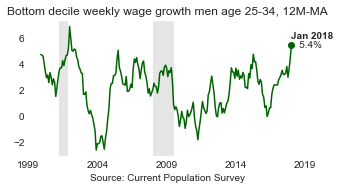

In [14]:
# Weekly wage growth
series = 'PRERNWA, PWORWGT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1) and (PRFTLF = 1) and (PRERNWA > 0)"
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth men age 25-34, 12M-MA'
data = get_cps_data(series, filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'darkgreen')

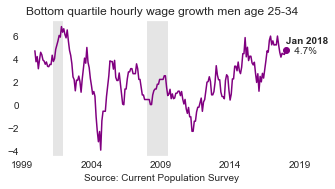

In [105]:
# Hourly wage growth
series = 'PRERNHLY, PWORWGT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1) and (PRFTLF = 1) and (PRERNHLY > 0)"
calc_type = 'uhe'
title = 'Bottom quartile hourly wage growth men age 25-34'
data = get_cps_data(series, filters, calc_type, decile=0.25)
labor_mkt_grapher(title, data, 'purple')

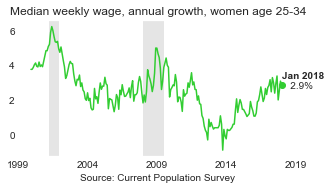

In [82]:
# Weekly wage growth
series = 'PRERNWA, PWORWGT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2) and (PRFTLF = 1) and (PRERNWA > 0)"
calc_type = 'uwe'
title = 'Median weekly wage, annual growth, women age 25-34'
data = get_cps_data(series, filters, calc_type, decile=0.5)
labor_mkt_grapher(title, data, 'limegreen')

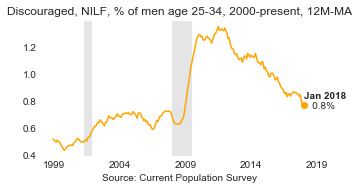

In [84]:
# Discouraged worker, or conditionally available
series = 'PRDISC'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'disc'
title = 'Discouraged, NILF, % of men age 25-34, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

The employment to population ratio calculates what share of the total population ($P$), has a job. It is calculated from the Current Population Survey (CPS).

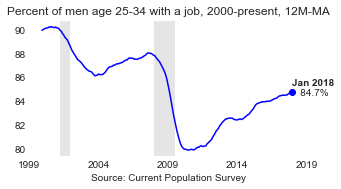

In [3]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'epop'
title = 'Percent of men age 25-34 with a job, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

### The share of men age 25-34 with a job has not recovered from its 2000 peak

There are essentially three labor force categories: employed, unemployed, and not in the labor force.

$$Population = Employed + Unemployed + Not \ in \ Labor \ Force$$

The employment-population ratio (above) is therefore $\frac{Employed}{Population}$. $Unemployed$ and $Not \ in \ Labor \ Force$ are different; $Unemployed$ counts those actively looking for work or recently layed off. People can be outside the labor force for many reasons, some more subject to economic factors than others.

The CPS gives 100,000 people a chance to tell their story each month, including why they are not in the labor force. We can use the survey responses to summarize trends across groups.

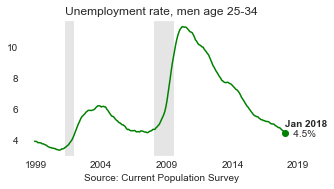

In [108]:
# Unemployment Rate
series = 'PREMPNOT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'unemp'
title = 'Unemployment rate, men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'green')

The unemployment rate has more or less recovered, unlike the employment to population ratio. It is calculated as the unemployed population divided by the labor force, $\frac{Unemployed}{(Employed+Unemployed)}$. We can also look at the labor force participation rate, $\frac{(Employed+Unemployed)}{Population}$, the least recovered of the three measures. 

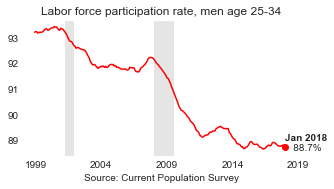

In [106]:
# Labor force participation rate
series = 'PREMPNOT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'lfpr'
title = 'Labor force participation rate, men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'red')

### Women

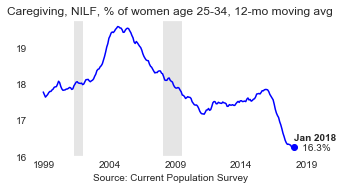

In [58]:
# Care for other, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 25-34, 12-mo moving avg'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

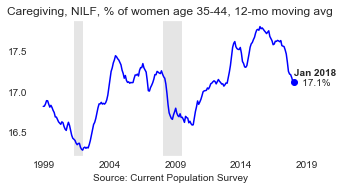

In [87]:
# Care for other, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 35 and 44) and (PESEX = 2)"
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 35-44, 12-mo moving avg'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

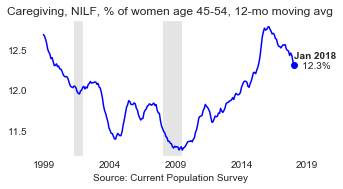

In [88]:
# Care for other, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 45 and 54) and (PESEX = 2)"
calc_type = 'care'
title = 'Caregiving, NILF, % of women age 45-54, 12-mo moving avg'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

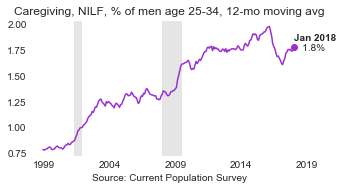

In [60]:
# Care for other, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'care'
title = 'Caregiving, NILF, % of men age 25-34, 12-mo moving avg'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'darkorchid')
plt.savefig('caregiving.png', bbox_inches='tight', dpi=500)

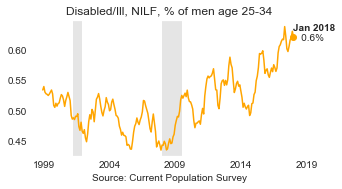

In [115]:
# Disabled/Ill, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'disill'
title = 'Disabled/Ill, NILF, % of men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

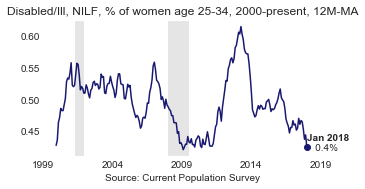

In [31]:
# Disabled/Ill, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'disill'
title = 'Disabled/Ill, NILF, % of women age 25-34, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'midnightblue')

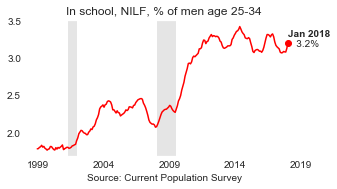

In [107]:
# In school, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'nilfsch'
title = 'In school, NILF, % of men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'red')

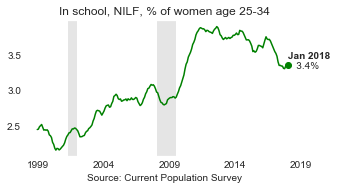

In [98]:
# In school, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'green')

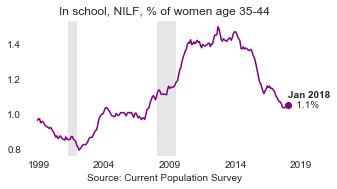

In [99]:
# In school, not in labor force
series = 'PENLFACT'
filters = "and (PRTAGE between 35 and 44) and (PESEX = 2)"
calc_type = 'nilfsch'
title = 'In school, NILF, % of women age 35-44'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'purple')

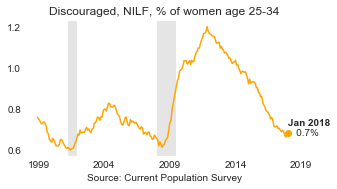

In [102]:
# Discouraged worker, or conditionally available
series = 'PRDISC'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'disc'
title = 'Discouraged, NILF, % of women age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'orange')

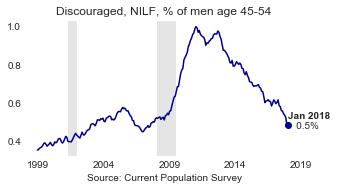

In [101]:
# Discouraged worker, or conditionally available
series = 'PRDISC'
filters = "and (PRTAGE between 45 and 54) and (PESEX = 1)"
calc_type = 'disc'
title = 'Discouraged, NILF, % of men age 45-54'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'darkblue')

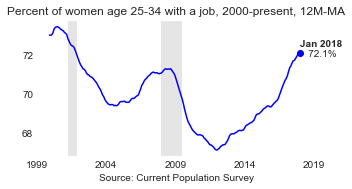

In [6]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'epop'
title = 'Percent of women age 25-34 with a job, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

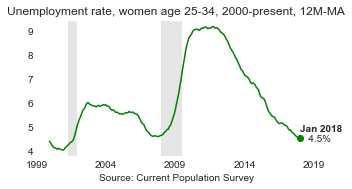

In [7]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, women age 25-34, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'green')

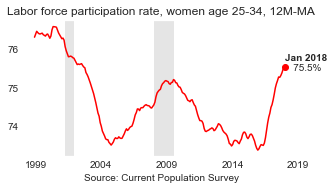

In [51]:
# Labor force participation rate
series = 'PREMPNOT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'lfpr'
title = 'Labor force participation rate, women age 25-34, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'red')
plt.savefig('lfpr.png', bbox_inches='tight', dpi=500)

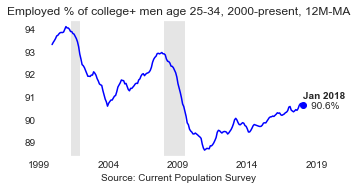

In [12]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'epop'
title = 'Employed % of college+ men age 25-34, 2000-present, 12M-MA'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

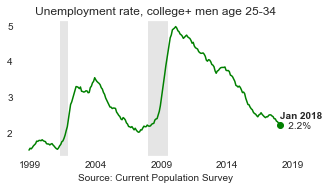

In [113]:
# Unemployment Rate
calc_type = 'unemp'
title = 'Unemployment rate, college+ men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'green')

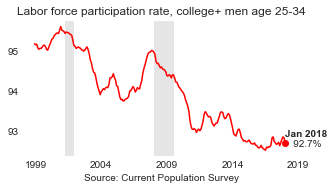

In [112]:
# Labor force participation rate
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 25 and 34) and (PESEX = 1)"
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ men age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'red')

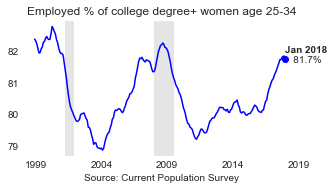

In [94]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'epop'
title = 'Employed % of college degree+ women age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

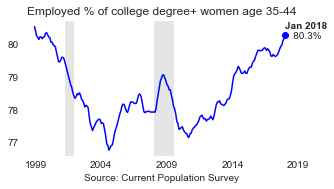

In [95]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 35 and 44) and (PESEX = 2)"
calc_type = 'epop'
title = 'Employed % of college degree+ women age 35-44'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

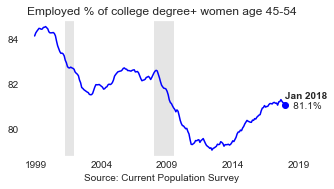

In [96]:
# Employment to Population Ratio
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 45 and 54) and (PESEX = 2)"
calc_type = 'epop'
title = 'Employed % of college degree+ women age 45-54'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'blue')

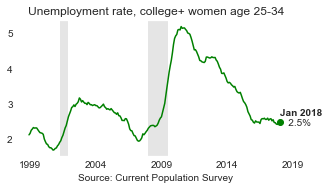

In [92]:
# Unemployment Rate
series = 'PREMPNOT'
filters = "and (PEEDUCA >= 43) and (PRTAGE between 25 and 34) and (PESEX = 2)"
calc_type = 'unemp'
title = 'Unemployment rate, college+ women age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'green')

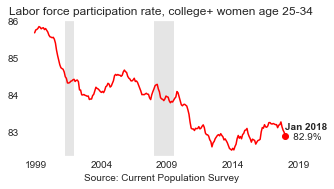

In [97]:
# Labor force participation rate
calc_type = 'lfpr'
title = 'Labor force participation rate, college+ women age 25-34'
data = get_cps_data(series, filters, calc_type)
labor_mkt_grapher(title, data, 'red')

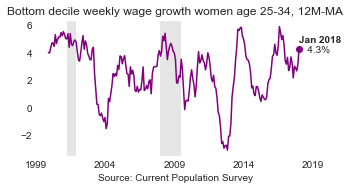

In [85]:
# Weekly wage growth
series = 'PRERNWA, PWORWGT'
filters = "and (PRTAGE between 25 and 34) and (PESEX = 2) and (PRFTLF = 1) and (PRERNWA > 0)"
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 25-34, 12M-MA'
data = get_cps_data(series, filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

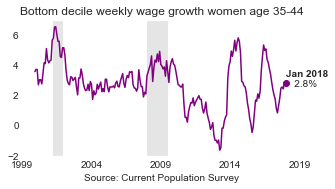

In [89]:
# Weekly wage growth
series = 'PRERNWA, PWORWGT'
filters = "and (PRTAGE between 35 and 44) and (PESEX = 2) and (PRFTLF = 1) and (PRERNWA > 0)"
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 35-44'
data = get_cps_data(series, filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')

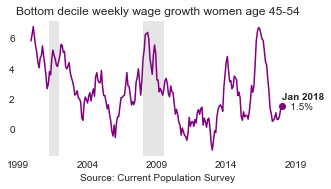

In [90]:
# Weekly wage growth
series = 'PRERNWA, PWORWGT'
filters = "and (PRTAGE between 45 and 54) and (PESEX = 2) and (PRFTLF = 1) and (PRERNWA > 0)"
calc_type = 'uwe'
title = 'Bottom decile weekly wage growth women age 45-54'
data = get_cps_data(series, filters, calc_type, decile=0.1)
labor_mkt_grapher(title, data, 'purple')